**DESAFIO MURABEI** - Ciclo 03

<font size=15>**Candidato:** Ricardo Martini Kato</font>

# 0.0 IMPORTS

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats as ss
from statsmodels.stats.diagnostic import lilliefors

import xgboost as xgb
import lightgbm as lgbm

from boruta import BorutaPy
from mrmr import mrmr_regression

from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

from matplotlib import pyplot as plt
from IPython.display import Image
from IPython.core.display import HTML

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
D:\Anaconda\programa\envs\kaggle_challenge\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## 0.1. FUNCTIONS

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'ggplot')
    plt.rcParams['figure.figsize'] = [24, 9]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
jupyter_settings()

def describe_num(num_attributes):
    a = num_attributes.describe().T.reset_index()
    
    d4 = pd.DataFrame(num_attributes.apply( lambda x: x.max() - x.min())).T
    d5 = pd.DataFrame(num_attributes.apply( lambda x: x.skew())).T      
    d6 = pd.DataFrame(num_attributes.apply( lambda x: x.kurtosis())).T
    d7 = pd.DataFrame(num_attributes.apply( lambda x: x.unique().shape[0])).T
    
    n = pd.concat([d4, d5, d6, d7], axis=0).T.reset_index()
    n.columns = ['attibutes', 'range', 'skew', 'kurtosis', 'unique']
    b = a.merge(n, right_on='attibutes', left_on='index')
    b.drop('index', axis=1, inplace=True)
    columns = ['attibutes', 'count', 'mean', 'std', '25%', '50%', '75%', 'min', 'max', 'range',
           'skew', 'kurtosis', 'unique']
    return b[columns]

def show_values_on_bars(axs):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height()
            value = '{:.2f}'.format(p.get_height())
            ax.text(_x, _y, value, ha="center") 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

def cramer_v(x,y):
    cm = pd.crosstab(x, y).values #no curso ele usa a função .as_matrix() que foi descontinuada.
    chi2 = ss.chi2_contingency(cm)[0]
    n = cm.sum()
    r, k = cm.shape
    chi2corr =  max(0, chi2 - (k-1)*(r-1)/(n-1))
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (k-1)**2/(n-1)
    return np.sqrt((chi2corr/n)/(min(kcorr-1,rcorr-1)))

def normal_test(normality_test):
    alpha = 0.05

    sf_t, k2_t, and_t, q2_t, lf_t, jb_t, ks_t = [[], [], [], [], [], [], []]
    name_columns = normality_test.columns

    for i in normality_test:
        if len(normality_test[i])<50:
            # Shapiro-Wilk Test - SAMPLE < 50
            statistic_wb, pvalue_wb = ss.shapiro(normality_test[i])        
            if pvalue_wb > alpha:
                sf_t = sf_t + ["H0 can be rejected - Prob. Gaussian"]
            else:
                sf_t = sf_t + ["H0 cannot be rejected - Prob. not Gaussian"]
        else:
            sf_t = sf_t + ['Test not possible']

        # D’Agostino’s K-squared test
        k2, p_k2 = ss.normaltest(normality_test[i])
        if p_k2 > alpha:
            k2_t = k2_t + ["H0 can be rejected - Prob. Gaussian"]
        else:
            k2_t = k2_t + ["H0 cannot be rejected - Prob. not Gaussian"]

        # Anderson-Darling Normality Test
        and_test = ss.anderson(normality_test[i], dist='norm')
        if and_test.statistic < and_test.critical_values[2]: #alpha = 0.05
            and_t = and_t + ["H0 can be rejected - Prob. Gaussian"]
        else:
            and_t = and_t + ["H0 cannot be rejected - Prob. not Gaussian"]

        # Chi-Square Normality Test
        statistic_q2, pvalue_q2 = ss.chisquare(normality_test[i])
        if pvalue_q2 > alpha:
            q2_t = q2_t + ["H0 can be rejected - Prob. Gaussian"]
        else:
            q2_t = q2_t + ["H0 cannot be rejected - Prob. not Gaussian"]

        # Lilliefors Test for Normality
        statistic_lillie, pvalue_lillie = lilliefors(normality_test[i])
        if pvalue_lillie > alpha:
            lf_t = lf_t + ["H0 can be rejected - Prob. Gaussian"]
        else:
            lf_t = lf_t + ["H0 cannot be rejected - Prob. not Gaussian"]

        #Jarque–Bera test for Normality (SAMPLES > 2000)
        if len(normality_test[i]) > 2000:
            statistic_jb, pvalue_jb = ss.jarque_bera(normality_test[i])
            alpha = 0.05
            if pvalue_jb > alpha:
                jb_t = jb_t + ["H0 can be rejected - Prob. Gaussian"]
            else:
                jb_t = jb_t + ["H0 cannot be rejected - Prob. not Gaussian"]
        else:
            jb_t = jb_t + ['Test not possible']

        # Kolmogorov-Smirnov test for Normality
        statistic_ks, pvalue_ks = ss.kstest(normality_test[i], 'norm')
        if pvalue_ks > alpha:
            ks_t = ks_t + ["H0 can be rejected - Prob. Gaussian"]
        else:
            ks_t = ks_t + ["H0 cannot be rejected - Prob. not Gaussian"]

    normal_t = pd.DataFrame([sf_t, k2_t, and_t, q2_t, lf_t, jb_t, ks_t], columns=name_columns).T
    normal_t.columns = ['Shapiro-Wilk Test', 'D’Agostino’s K-squared',
                    'Anderson-Darling', 'Chi-Square',
                    'Lilliefors', 'Jarque–Bera', 'Kolmogorov-Smirnov']
    
    return normal_t
        
pd.options.display.float_format = '{:.4f}'.format

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading data
**-Variables Description**
* school - School ID
* schgend - School gender
* type - School type
* normexam - Normalized exam score
* schavg - School average of intake socre
* vr - Student level Verbal Reasoning (VR) socre band at intake
* intake - Band of student´s intake score
* standLRT - Standardised LR test score
* sex - Sex of the student - 'F' or 'M'
* Student - Student id (within school)


In [3]:
df_cat_sc = pd.read_csv('cat_school_data.csv', sep=';')
df_cat_st = pd.read_csv('cat_student_data.csv', sep=';')
df_num_sc = pd.read_csv('num_school_data.csv', sep=';')
df_num_st = pd.read_csv('num_student_data.csv', sep=';')

**Ciclo 02: De maneira a verificar os NA gerados nos dois ciclos anteriores, será verificado a sua fonte na etapa de tratamento dos dados**

### 0.2.1 SCHOOL DATA

In [4]:
# Ajustando tabela Categorical School
aux1 = df_cat_sc.iloc[:65,:].copy().reset_index(drop=True).drop(columns='variable')
aux1.columns = ['school', 'schgend']
aux2 = df_cat_sc.iloc[65:,:].copy().reset_index(drop=True).drop(columns=['school','variable'])
aux2.columns = ['type']
df_cat_sc_adj = pd.concat([aux1, aux2], axis=1)

# ajustando a tabela - apenas 65 registro com uma única variável: shavg
df_num_sc = df_num_sc.rename(columns={'value': 'schavg'}).drop(columns='variable')

# Juntando tabelas School
df_school = pd.merge(df_cat_sc_adj, df_num_sc, on='school', how='left')

In [5]:
# PS:. Não existe NA gerado nesta etapa
df_school.isna().sum()

school     0
schgend    0
type       0
schavg     0
dtype: int64

### 0.2.2 STUDENT DATA

Analisando a contagem por categoria (variável)
* É possível verificar que os NA são gerados pela defasagem de dados entre aqueles categóricos e numéricos. Sendo que existem no total 4059 alunos matriculados dentro dos dados numéricos e estes variam nas variáveis categóricas, no qual o 'sex' são aqueles que apresenta o menor número 3919. Entretanto, vale destacar que existem 90 alunos sem identificação, o que pode corresponder a falha no cadastro destes alunos na base.

In [6]:
# verificando a contagem por nível
df_cat_st['variable'].value_counts()

vr        3962
intake    3947
sex       3919
Name: variable, dtype: int64

In [7]:
df_cat_st.isna().sum()

school      0
student     0
variable    0
value       0
dtype: int64

In [8]:
# verificando a contagem por nível
df_num_st['variable'].value_counts()

normexam    4059
standLRT    4059
Name: variable, dtype: int64

In [9]:
df_num_st.isna().sum()

school        0
student      90
variable      0
value       101
dtype: int64

In [10]:
# Total de NAs por escola - Valores duplicados por que ocorre o par normexam e standLRT
st_a = df_num_st[df_num_st['student'].isna()]
gr_st_a = st_a[['school']].groupby('school').size().reset_index().rename(columns={0: 'student_na'})
gr_st_a

,school,student_na
0,1,2
1,2,2
2,3,2
3,4,2
4,13,2
5,14,4
6,17,4
7,18,2
8,20,2
9,22,4


In [11]:
st_b = df_num_st[df_num_st['value'].isna()]
gr_st_b = st_b[['school', 'variable']].groupby(['school', 'variable']).size().reset_index().rename(columns={0: 'variable_na'})
print('NA por categoria - normexam: ', gr_st_b[gr_st_b['variable'] == 'normexam']['variable_na'].sum(), ' standLRT: ', gr_st_b[gr_st_b['variable'] == 'standLRT']['variable_na'].sum())

NA por categoria - normexam:  72  standLRT:  29


- o método dos ciclos 00 e 01 atribuiu valor 999 aos valores de students com NAs, entretanto há mais de um aluno por escola o que gerou NAs nos ciclos anteriores ao juntar os DF. Será adotado uma nova estrategia realizando concat e merge entre os DF ao invés de concatenar as strings simplesmente para mapear onde ocorrem os NAs.

##### FUNÇÂO Verificando dados duplicados

In [12]:
def verificar_duplicado(df_alvo, variavel):
    df_filtrado = df_alvo[df_alvo['variable']==variavel].copy()
    df_resumo = df_filtrado[['school', 'student']].groupby(['school']).count().reset_index().rename(columns={'student': 'count'})
    
    df_resumo['diff'] = 0
    for i in range(len(df_filtrado['school'])):
        sc_ft = df_alvo[(df_alvo['school']==i+1) & (df_alvo['variable']==variavel)]
        df_resumo['diff'][i] = sc_ft.loc[sc_ft.duplicated(subset='student', keep=False), :].shape[0]
    
    return df_resumo

#####  Dados numéricos

In [13]:
df_num_st_sna = df_num_st[~df_num_st['student'].isna()]
dp_normexam = verificar_duplicado(df_num_st_sna, 'normexam')
dp_normexam[dp_normexam['diff'] > 0]

,school,count,diff
42,43,61,2
49,50,71,2
51,52,61,4


In [14]:
dp_standLRT = verificar_duplicado(df_num_st_sna, 'standLRT')
dp_standLRT[dp_standLRT['diff'] > 0]

,school,count,diff
42,43,61,2
49,50,71,2
51,52,61,4


In [15]:
# verificando os valores duplicados 
# - School 43 - student 86
# - School 50 - student 39
# - School 52 - student 2 e 21
#sc_ft = df_num_st[(df_num_st['school']==52) & (df_num_st['variable']=='standLRT')]
#sc_ft.loc[sc_ft.duplicated(subset='student', keep=False), :]

In [16]:
df_num_st.shape

(8118, 4)

* há valores duplicados para o número de cadastro do estudante para o dataset numérico. Como não temos o contexto da inserção destes dados, para garantia e consistência do modelo estes valores serão removidos. Poderão retornar caso seja esclarecido. Entretanto, a regra é ter um número único de estudante por escola e isso não se confirma em algumas

In [17]:
# há valores duplicados para o número de cadastro do estudante. Como não temos o contexto da inserção destes dados, para garantia e consistência do modelo estes valores serão removidos para o modelo.
rm_index = []

# VARIAVEL NORMEXAM
sc_ft = df_num_st[(df_num_st['school']==43) & (df_num_st['variable']=='normexam')]
rm_index = rm_index + sc_ft.loc[sc_ft.duplicated(subset='student', keep=False), :].index.tolist()
sc_ft = df_num_st[(df_num_st['school']==50) & (df_num_st['variable']=='normexam')]
rm_index = rm_index + sc_ft.loc[sc_ft.duplicated(subset='student', keep=False), :].index.tolist()
sc_ft = df_num_st[(df_num_st['school']==52) & (df_num_st['variable']=='normexam')]
rm_index = rm_index + sc_ft.loc[sc_ft.duplicated(subset='student', keep=False), :].index.tolist()

# VARIAVEL standLRT
sc_ft = df_num_st[(df_num_st['school']==43) & (df_num_st['variable']=='standLRT')]
rm_index = rm_index + sc_ft.loc[sc_ft.duplicated(subset='student', keep=False), :].index.tolist()
sc_ft = df_num_st[(df_num_st['school']==50) & (df_num_st['variable']=='standLRT')]
rm_index = rm_index + sc_ft.loc[sc_ft.duplicated(subset='student', keep=False), :].index.tolist()
sc_ft = df_num_st[(df_num_st['school']==52) & (df_num_st['variable']=='standLRT')]
rm_index = rm_index + sc_ft.loc[sc_ft.duplicated(subset='student', keep=False), :].index.tolist()

df_num_st = df_num_st[~df_num_st.index.isin(rm_index)]
df_num_st.shape

(8098, 4)

In [18]:
# DF STUDENTS NUMERICO
# ordenando e ajustando o DF 
df_num_st_sorted = df_num_st.sort_values(['school', 'variable', 'student'])

df_num_st_corr = pd.DataFrame()
for sc in range(len(df_num_st_sorted['school'].unique())):
    nivel_sc = df_num_st_sorted[df_num_st_sorted['school'] == sc+1]
    normexam_sc = nivel_sc[nivel_sc['variable'] == 'normexam'].reset_index(drop=True)
    standLRT_sc = nivel_sc[nivel_sc['variable'] == 'standLRT'].reset_index(drop=True)
    norm_standLRT = pd.concat([normexam_sc, standLRT_sc], axis=1)
    df_num_st_corr = pd.concat([df_num_st_corr, norm_standLRT], axis=0)

df_num_st_corr.columns = ['school_ne', 'student_ne', 'variable_ne', 'value_ne', 'school_st', 'student_st', 'variable_st', 'value_st']    
# verificando se há correspondência exata
df_num_st_corr['match'] = (df_num_st_corr['student_ne'] == df_num_st_corr['student_st'])
df_num_st_corr[df_num_st_corr['match'] == False] # o falso só ocorre quando o aluno é NaN

,school_ne,student_ne,variable_ne,value_ne,school_st,student_st,variable_st,value_st,match
72,1,NaN,normexam,"1,5061852",1,NaN,standLRT,"0,5364082",False
54,2,NaN,normexam,"-1,438662",2,NaN,standLRT,"-2,76965",False
51,3,NaN,normexam,"-0,939378",3,NaN,standLRT,"-0,290107",False
78,4,NaN,normexam,"0,1941492",4,NaN,standLRT,"-0,042152",False
63,13,NaN,normexam,"-1,219486",13,NaN,standLRT,"-2,934953",False
196,14,NaN,normexam,"-0,492781",14,NaN,standLRT,"0,7017112",False
197,14,NaN,normexam,"1,1758492",14,NaN,standLRT,"1,6935282",False
124,17,NaN,normexam,"-0,419801",17,NaN,standLRT,"0,9496652",False
125,17,NaN,normexam,"-1,836687",17,NaN,standLRT,"-2,934953",False
119,18,NaN,normexam,"0,0043222",18,NaN,standLRT,"0,7017112",False


In [19]:
# ajustando DF para junção das variáveis categóricas
df_num_st_corr = df_num_st_corr.drop(columns=['variable_ne', 'school_st', 'student_st', 'variable_st', 'match']).reset_index(drop=True)
df_num_st_corr.columns = ['school', 'student', 'normexam', 'standLRT']

# Como foi ajustado agora o formato do DF numerico colocando normexam/standLRT lado a lado, é possível realizar a substituição dos NA por alunos fictícios sem gerar valores duplicados.
# Entretanto, considerará que os valores de normexam/standLRT pertencem ao mesmo aluno fictício.
aux_na = df_num_st_corr[df_num_st_corr['student'].isna()]
aux_na['student_nv'] = np.arange( 1001, 1001+len( aux_na ), 1) 
st_nv = aux_na.index.tolist()
df_num_st_corr.loc[st_nv,'student'] = aux_na[['student_nv']].values

# a partir disso é possível converter os valores para int
df_num_st_corr['student'] = df_num_st_corr['student'].astype('int')

In [20]:
df_num_st_corr.isna().sum()

school       0
student      0
normexam    71
standLRT    29
dtype: int64

##### DADOS CATEGORICOS

In [21]:
dp_intake = verificar_duplicado(df_cat_st, 'intake')
dp_intake[dp_intake['diff'] > 0]

,school,count,diff
42,43,61,2
49,50,68,2
51,52,59,4


In [22]:
dp_vr = verificar_duplicado(df_cat_st, 'vr')
dp_vr[dp_vr['diff'] > 0]

,school,count,diff
42,43,60,2
49,50,70,2
51,52,61,4


In [23]:
dp_sex = verificar_duplicado(df_cat_st, 'sex')
dp_sex[dp_sex['diff'] > 0]

,school,count,diff
42,43,58,2
49,50,70,2
51,52,61,4


In [24]:
df_cat_st.shape

(11828, 4)

In [25]:
# analisando os dados retornado como duplicados para as variaveis categoricas, os mesmos alunos retornaram dos dados numericos também apareceram. 
# Tendo em vista que já foram removidos da outra base, a mesma regra será aplicado
rm_index = []

#intake
sc_ft = df_cat_st[(df_cat_st['school']==43) & (df_cat_st['variable']=='intake')]
rm_index = rm_index + sc_ft.loc[sc_ft.duplicated(subset='student', keep=False), :].index.tolist()
sc_ft = df_cat_st[(df_cat_st['school']==50) & (df_cat_st['variable']=='intake')]
rm_index = rm_index + sc_ft.loc[sc_ft.duplicated(subset='student', keep=False), :].index.tolist()
sc_ft = df_cat_st[(df_cat_st['school']==52) & (df_cat_st['variable']=='intake')]
rm_index = rm_index + sc_ft.loc[sc_ft.duplicated(subset='student', keep=False), :].index.tolist()

#vr
sc_ft = df_cat_st[(df_cat_st['school']==43) & (df_cat_st['variable']=='vr')]
rm_index = rm_index + sc_ft.loc[sc_ft.duplicated(subset='student', keep=False), :].index.tolist()
sc_ft = df_cat_st[(df_cat_st['school']==50) & (df_cat_st['variable']=='vr')]
rm_index = rm_index + sc_ft.loc[sc_ft.duplicated(subset='student', keep=False), :].index.tolist()
sc_ft = df_cat_st[(df_cat_st['school']==52) & (df_cat_st['variable']=='vr')]
rm_index = rm_index + sc_ft.loc[sc_ft.duplicated(subset='student', keep=False), :].index.tolist()

#sex
sc_ft = df_cat_st[(df_cat_st['school']==43) & (df_cat_st['variable']=='sex')]
rm_index = rm_index + sc_ft.loc[sc_ft.duplicated(subset='student', keep=False), :].index.tolist()
sc_ft = df_cat_st[(df_cat_st['school']==50) & (df_cat_st['variable']=='sex')]
rm_index = rm_index + sc_ft.loc[sc_ft.duplicated(subset='student', keep=False), :].index.tolist()
sc_ft = df_cat_st[(df_cat_st['school']==52) & (df_cat_st['variable']=='sex')]
rm_index = rm_index + sc_ft.loc[sc_ft.duplicated(subset='student', keep=False), :].index.tolist()

df_cat_st = df_cat_st[~df_cat_st.index.isin(rm_index)]
df_cat_st.shape

(11804, 4)

In [26]:
# Checagem
# sc_ft = df_cat_st[(df_cat_st['school']==52) & (df_cat_st['variable']=='vr')]
# sc_ft.loc[sc_ft.duplicated(subset='student', keep=False), :]

In [27]:
# ordenando e ajustando o DF
df_cat_st_sorted = df_cat_st.sort_values(['school', 'variable', 'student'])

df_cat_st_corr = pd.DataFrame()
for sc in range(len(df_cat_st_sorted['school'].unique())):
    nivel_sc = df_cat_st_sorted[df_cat_st_sorted['school'] == sc+1]
    intake_sc = nivel_sc[nivel_sc['variable'] == 'intake'].reset_index(drop=True)
    vr_sc = nivel_sc[nivel_sc['variable'] == 'vr'].reset_index(drop=True)
    sex_sc = nivel_sc[nivel_sc['variable'] == 'sex'].reset_index(drop=True)
    intake_vr = pd.merge(intake_sc, vr_sc, on='student', how='left')
    intake_vr_sex = pd.merge(intake_vr, sex_sc, on='student', how='left')
    df_cat_st_corr = pd.concat([df_cat_st_corr, intake_vr_sex], axis=0)

df_cat_st_corr.columns = ['school_it', 'student_it', 'variable_it', 'value_it', 'school_vr', 'variable_vr', 'value_vr', 'school_sex', 'variable_sex', 'value_sex']
df_cat_st_corr = df_cat_st_corr.drop(columns=['variable_it', 'school_vr', 'variable_vr','school_sex', 'variable_sex'])
df_cat_st_corr.columns = ['school', 'student', 'intake', 'vr', 'sex']

In [28]:
df_cat_st_corr.isna().sum()
# verificando o dataframe, realmente há ausência de alunos entre as variáveis. Ou seja, existem alunos da escola 1 que possuem intake e vr, porém sex está ausente. 
# Entretanto, como pode-se verificar no DF, vr é constante para cada escola e sex pode-se obter a partir dos dados da escola quando juntar os DF.

school      0
student     0
intake      0
vr         52
sex        94
dtype: int64

In [29]:
# tendo em vista que vr é constante por escola. vamos adicionar essa variável no df_school para facilitar a junção de todos
df_vr = df_cat_st_corr[['school', 'vr']].groupby(['school', 'vr']).size().reset_index().drop(columns=0)
df_school = pd.merge(df_school, df_vr, on='school', how='left')

# removendo vr do df de estudante
df_cat_st_corr = df_cat_st_corr.drop(columns='vr')

In [30]:
df_student = pd.DataFrame()
for sc in range(len(df_num_st_corr['school'].unique())):
    st_num = df_num_st_corr[df_num_st_corr['school'] == sc+1]
    st_cat = df_cat_st_corr[df_cat_st_corr['school'] == sc+1]
    st_num_cat = pd.merge(st_num, st_cat, on='student', how='left')
    df_student = pd.concat([df_student, st_num_cat], axis=0)
    
df_student = df_student.drop('school_y', axis=1).rename(columns={'school_x':'school'})

In [31]:
df_student.isna().sum()
# analisando os NA obtidos
# - Mantido quantidade de NA normexam e standLRT já ausentes no DF original, entretanto estes dados ausentes são irrecuperáveis
# - os NA das demais variáveis são devido a quantidade de alunos na base de estudantes ser maior que a categórica. Estes dados são também irrecuperáveis.
# IMPORTANTE: os valores ausentes são intrísecos aos candidatos, no qual qualquer valor atribuido poderá enviezar o modelo (média). 
# Utilizar regressão (standLRT) ou classificação (intake) para substituir os NAs poderão apresentar valores arbitários, no qual não farão sentido adotar no modelo.

school        0
student       0
normexam     71
standLRT     29
intake      110
sex         204
dtype: int64

In [32]:
df_student.head()

,school,student,normexam,standLRT,intake,sex
0,1,1,"1,5061852","0,7843622",bottom 25%,F
1,1,4,"-0,555112","-1,03397",mid 50%,F
2,1,6,"-1,335315","-0,951318",mid 50%,M
3,1,7,"-0,555112","-2,356393",top 25%,M
4,1,13,"-0,197611","-0,290107",mid 50%,M


### 0.2.3 FINAL DATAFRAME

In [33]:
df_student['school'] = df_student['school'].astype('int')
df_raw = pd.merge(df_student, df_school, on='school', how='left')

In [34]:
df_raw.head()

,school,student,normexam,standLRT,intake,sex,schgend,type,schavg,vr
0,1,1,"1,5061852","0,7843622",bottom 25%,F,mixed,Mxd,"0,1661752",mid 50%
1,1,4,"-0,555112","-1,03397",mid 50%,F,mixed,Mxd,"0,1661752",mid 50%
2,1,6,"-1,335315","-0,951318",mid 50%,M,mixed,Mxd,"0,1661752",mid 50%
3,1,7,"-0,555112","-2,356393",top 25%,M,mixed,Mxd,"0,1661752",mid 50%
4,1,13,"-0,197611","-0,290107",mid 50%,M,mixed,Mxd,"0,1661752",mid 50%


# 1.0 DATA DESCRIPTION

In [35]:
df1 = df_raw.copy()

## 1.1 Rename Colums

In [36]:
df1.columns

Index(['school', 'student', 'normexam', 'standLRT', 'intake', 'sex', 'schgend',
       'type', 'schavg', 'vr'],
      dtype='object')

## 1.2 Data Dimensions

In [37]:
print('Number of Rows: {}'.format (df1.shape[0]))
print('Number of Rows: {}'.format (df1.shape[1]))

Number of Rows: 4049
Number of Rows: 10


## 1.3 Data Types

In [38]:
df1.dtypes

school       int32
student      int32
normexam    object
standLRT    object
intake      object
sex         object
schgend     object
type        object
schavg      object
vr          object
dtype: object

## 1.4 Check NA

In [39]:
df_na = pd.DataFrame(df1.isna().sum(), columns=['NA'])
df_na['%'] = round(df_na['NA']/len(df1)*100, 2)
df_na

,NA,%
school,0,0.0000
student,0,0.0000
normexam,71,1.7500
standLRT,29,0.7200
intake,110,2.7200
sex,204,5.0400
schgend,0,0.0000
type,0,0.0000
schavg,0,0.0000
vr,0,0.0000


## 1.5 Fillout NA

In [40]:
# Nos ciclos anteriores não foi analisado os NA gerados, no qual verificou-se diversas incosistência. (df1 nos ciclos 00 e 01 - (3904, 9))
# Vale ressaltar que conforme discutido no tratamento dos dados, os NA agora presente não possíveis de recuperar e neste sentido serão removidos para o modelo.
# Ao remover estes valores, ficou com apenas 3842 uma redução de 5% dos dados considerando todos os estudantes existentes na base original.
df1_ = df1.copy()
df1_ = df1_.dropna(subset=['normexam', 'standLRT', 'intake'])
df1_ = df1_.drop(columns='sex') #remover sex no qual não há relevância para o modelo (essa variável já é explicado por schgend)
df1_.shape

(3842, 9)

## 1.6 Change Types

In [41]:
df1_.dtypes

school       int32
student      int32
normexam    object
standLRT    object
intake      object
schgend     object
type        object
schavg      object
vr          object
dtype: object

In [42]:
df1_['normexam'] = df1_['normexam'].apply(lambda x: x.replace(',', '.'))
df1_['standLRT'] = df1_['standLRT'].apply(lambda x: x.replace(',', '.'))
df1_['schavg'] = df1_['schavg'].apply(lambda x: x.replace(',', '.'))

numerical = ['normexam', 'standLRT', 'schavg']
df1_[numerical] = df1_[numerical].astype('float64')

In [43]:
df1_.head()

,school,student,normexam,standLRT,intake,schgend,type,schavg,vr
0,1,1,1.5062,0.7844,bottom 25%,mixed,Mxd,0.1662,mid 50%
1,1,4,-0.5551,-1.0340,mid 50%,mixed,Mxd,0.1662,mid 50%
2,1,6,-1.3353,-0.9513,mid 50%,mixed,Mxd,0.1662,mid 50%
3,1,7,-0.5551,-2.3564,top 25%,mixed,Mxd,0.1662,mid 50%
4,1,13,-0.1976,-0.2901,mid 50%,mixed,Mxd,0.1662,mid 50%


## 1.7 Descriptive Statistical

In [44]:
num_attributes = df1_.select_dtypes(include=('int64', 'float64'))
cat_attributes = df1_.select_dtypes(exclude=('int64', 'float64', 'datetime64[ns]'))

### 1.7.1 Numerical Attibutes

In [45]:
describe_num(num_attributes)

,attibutes,count,mean,std,25%,50%,75%,min,max,range,skew,kurtosis,unique
0,normexam,3842.0000,0.0052,0.9981,-0.6995,0.0043,0.6788,-3.6661,3.6661,7.3322,0.0108,0.0059,71.0000
1,standLRT,3842.0000,0.0115,0.9883,-0.6207,0.0405,0.6191,-2.9350,3.0160,5.9509,-0.1182,0.0747,70.0000
2,schavg,3842.0000,0.0032,0.3167,-0.1493,-0.0131,0.2674,-0.7560,0.6377,1.3936,-0.2201,-0.3575,65.0000


**CICLO 02 - Atual**
* 'normexam' - Não houve alteração do intervalo, porém a média aumentou de -0.0067 para 0.0052, consequentemente alterando também a sua skew para positiva. 
* 'standLRT' - Intervalo manteve-se. Média alterou, porém quase nada mantendo a configuração da curva do ciclo anterior.
* 'schavg' - Sem alteração do intervalo. Mudança da média para 0.0032 com redução da skew e mantendo a kurtose negativa.

**CICLO 00 e 01**
* 'normexam' - O interval das notas é entre -3.6661 a 3.6661. A mediana é 0.0043 e a média -0.0067 o que indica um skew positivo bem baixo (0.0186) e uma curva achatada (kurtosis negativa)
* 'standLRT' - O interval das notas é entre -2.9350 a 3.0160. A mediana é 0.6191 e a média 0.0068 o que indica um skew negativo baixo (-0.1069) e uma curva com tendência acentuada (kurtosis positiva)
* 'schavg' - O interval das notas é entre -0.7560 a 0.6377. A mediana é -0.0131 e a média 0.0111 o que indica um skew negativo mais acentuado (-0.2579) e uma curva achatada (kurtosis negativa)

### 1.7.2 Categorical Attibutes

In [46]:
cat_attributes.apply( lambda x: x.unique().shape[0])

school      65
student    635
intake       3
schgend      3
type         2
vr           3
dtype: int64

In [47]:
cat_attributes['student'].shape[0]

3842

* 'school' - total de 65 escolas cadastradas
* 'sc_st' - 3842 estudantes cadastrados nas 65 escolas
* 'intake' - possui 3 categorias: 'bottom 25%', 'mid 50%', 'top 25%'
* 'vr' - possui 3 categorias: 'bottom 25%', 'mid 50%', 'top 25%'
* 'schgend' - possui 3 categorias: 'mixed', 'girls', 'boys'
* 'type' - possui 2 categorias: 'Mxd', 'Sngl'

# 2.0 FEATURE ENGINEERING

In [48]:
# Não há muito contexto sobre as variáveis e desta maneira não será feito feature engineering
df2 = df1_.copy()
df2.head()

,school,student,normexam,standLRT,intake,schgend,type,schavg,vr
0,1,1,1.5062,0.7844,bottom 25%,mixed,Mxd,0.1662,mid 50%
1,1,4,-0.5551,-1.0340,mid 50%,mixed,Mxd,0.1662,mid 50%
2,1,6,-1.3353,-0.9513,mid 50%,mixed,Mxd,0.1662,mid 50%
3,1,7,-0.5551,-2.3564,top 25%,mixed,Mxd,0.1662,mid 50%
4,1,13,-0.1976,-0.2901,mid 50%,mixed,Mxd,0.1662,mid 50%


# 3.0 FEATURE FILTERING

In [49]:
df3 = df2.copy()
df3.head()

,school,student,normexam,standLRT,intake,schgend,type,schavg,vr
0,1,1,1.5062,0.7844,bottom 25%,mixed,Mxd,0.1662,mid 50%
1,1,4,-0.5551,-1.0340,mid 50%,mixed,Mxd,0.1662,mid 50%
2,1,6,-1.3353,-0.9513,mid 50%,mixed,Mxd,0.1662,mid 50%
3,1,7,-0.5551,-2.3564,top 25%,mixed,Mxd,0.1662,mid 50%
4,1,13,-0.1976,-0.2901,mid 50%,mixed,Mxd,0.1662,mid 50%


In [50]:
# Columns
# 'Type' - Apenas representa se é mxd ou sngl no qual acaba representando o mesmo que 'schgend'
df3 = df3.drop(columns='type')

# 4.0 EXPLORATORY DATA ANALYSIS

In [51]:
df4 = df3.copy()
df4.head()

,school,student,normexam,standLRT,intake,schgend,schavg,vr
0,1,1,1.5062,0.7844,bottom 25%,mixed,0.1662,mid 50%
1,1,4,-0.5551,-1.0340,mid 50%,mixed,0.1662,mid 50%
2,1,6,-1.3353,-0.9513,mid 50%,mixed,0.1662,mid 50%
3,1,7,-0.5551,-2.3564,top 25%,mixed,0.1662,mid 50%
4,1,13,-0.1976,-0.2901,mid 50%,mixed,0.1662,mid 50%


In [52]:
num_attributes = df4.select_dtypes(include=('int64', 'float64'))
cat_attributes = df4.select_dtypes(exclude=('int64', 'float64', 'datetime64[ns]'))

## 4.1. UNIVARIABLE ANALYSIS

### 4.1.1. RESPONSE VARIABLE

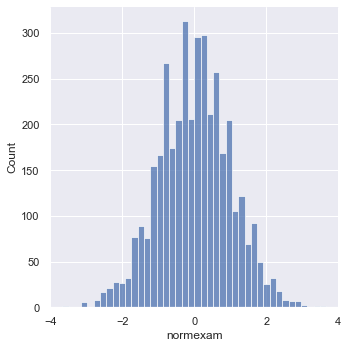

In [53]:
sns.displot(df4['normexam'])

### 4.1.2. NUMERICAL VARIABLE

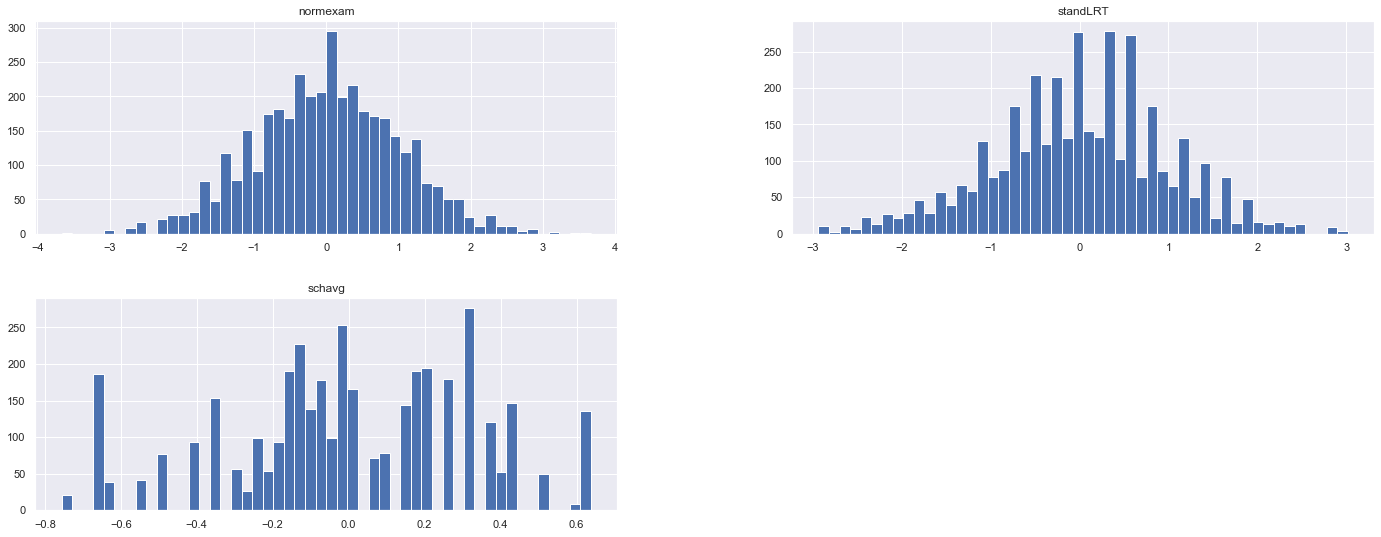

In [54]:
num_attributes.hist(bins=50);

### 4.1.3. CATEGORICAL VARIABLE

In [55]:
cat_attributes.columns

Index(['school', 'student', 'intake', 'schgend', 'vr'], dtype='object')

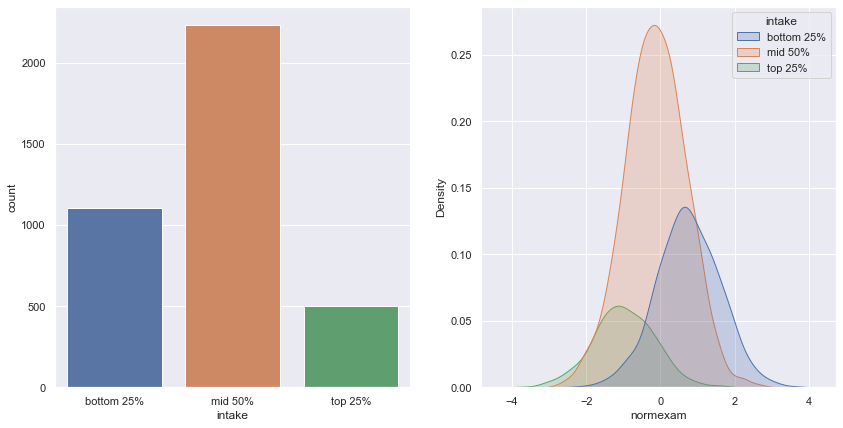

In [56]:
#intake
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
sns.countplot(data=df4, x='intake')

plt.subplot(1, 2, 2)
sns.kdeplot(data=df4, x='normexam', hue='intake', shade=True);

# COMENTARIO: Há uma inversão, no qual aqueles que possuem intake abaixo de 25% possuem normexam médio mais altos daqueles que obtiveram intake no top 25%. 
# Aqueles enquadrados no mid 50% possuem uma distribuição centralizada (aparentemente normal) no normexam

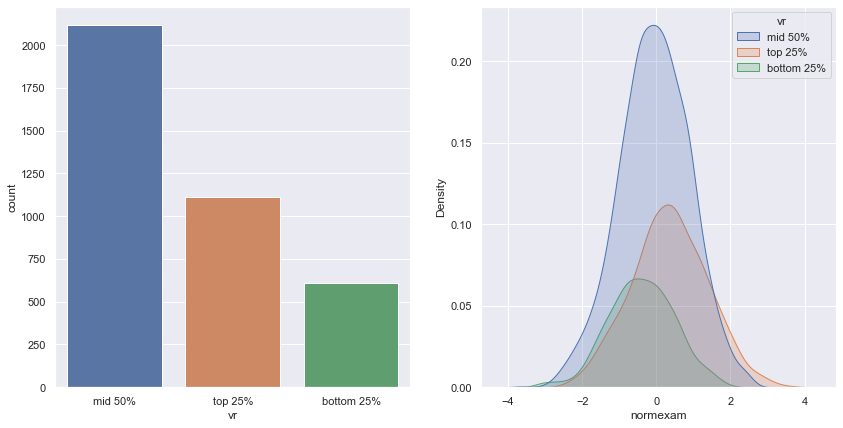

In [57]:
#vr
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
sns.countplot(data=df4, x='vr')

plt.subplot(1, 2, 2)
sns.kdeplot(data=df4, x='normexam', hue='vr', shade=True);

# COMENTÁRIO: vr na faixa top25% possui notas maiores em média no normexam e oposto ocorre com o botton25% porém não muito distante.

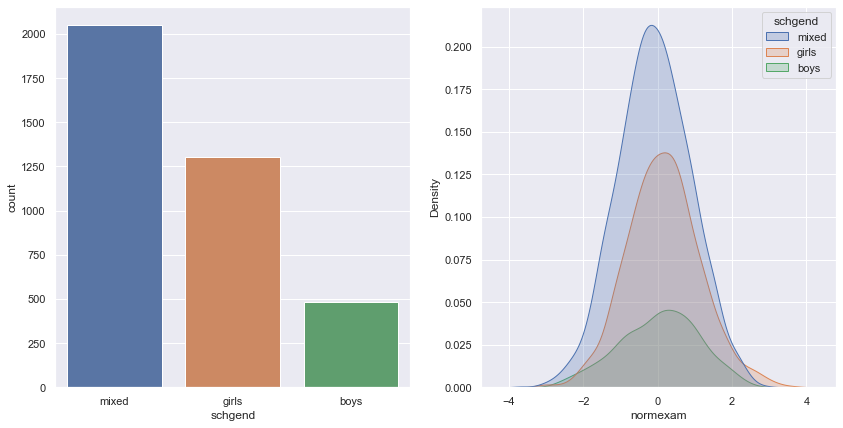

In [58]:
#schgend
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
sns.countplot(data=df4, x='schgend')

plt.subplot(1, 2, 2)
sns.kdeplot(data=df4, x='normexam', hue='schgend', shade=True);

# COMENTÁRIO: há uma aparente centralização das notas normexam para a variável schgend sem uma evidência nítida para o tipo de gênero da escola. 
# Houve um ligeiro deslocamento para direita, porém nada expressivo comparado ciclo anterior.

In [59]:
df4[['normexam', 'schgend']].groupby('schgend').mean()

,normexam
schgend,
boys,0.0317
girls,0.1507
mixed,-0.0937


## 4.2. BIVARIABLE ANALYSIS

In [60]:
df4.head()

,school,student,normexam,standLRT,intake,schgend,schavg,vr
0,1,1,1.5062,0.7844,bottom 25%,mixed,0.1662,mid 50%
1,1,4,-0.5551,-1.0340,mid 50%,mixed,0.1662,mid 50%
2,1,6,-1.3353,-0.9513,mid 50%,mixed,0.1662,mid 50%
3,1,7,-0.5551,-2.3564,top 25%,mixed,0.1662,mid 50%
4,1,13,-0.1976,-0.2901,mid 50%,mixed,0.1662,mid 50%


### normexam vs stndLRT

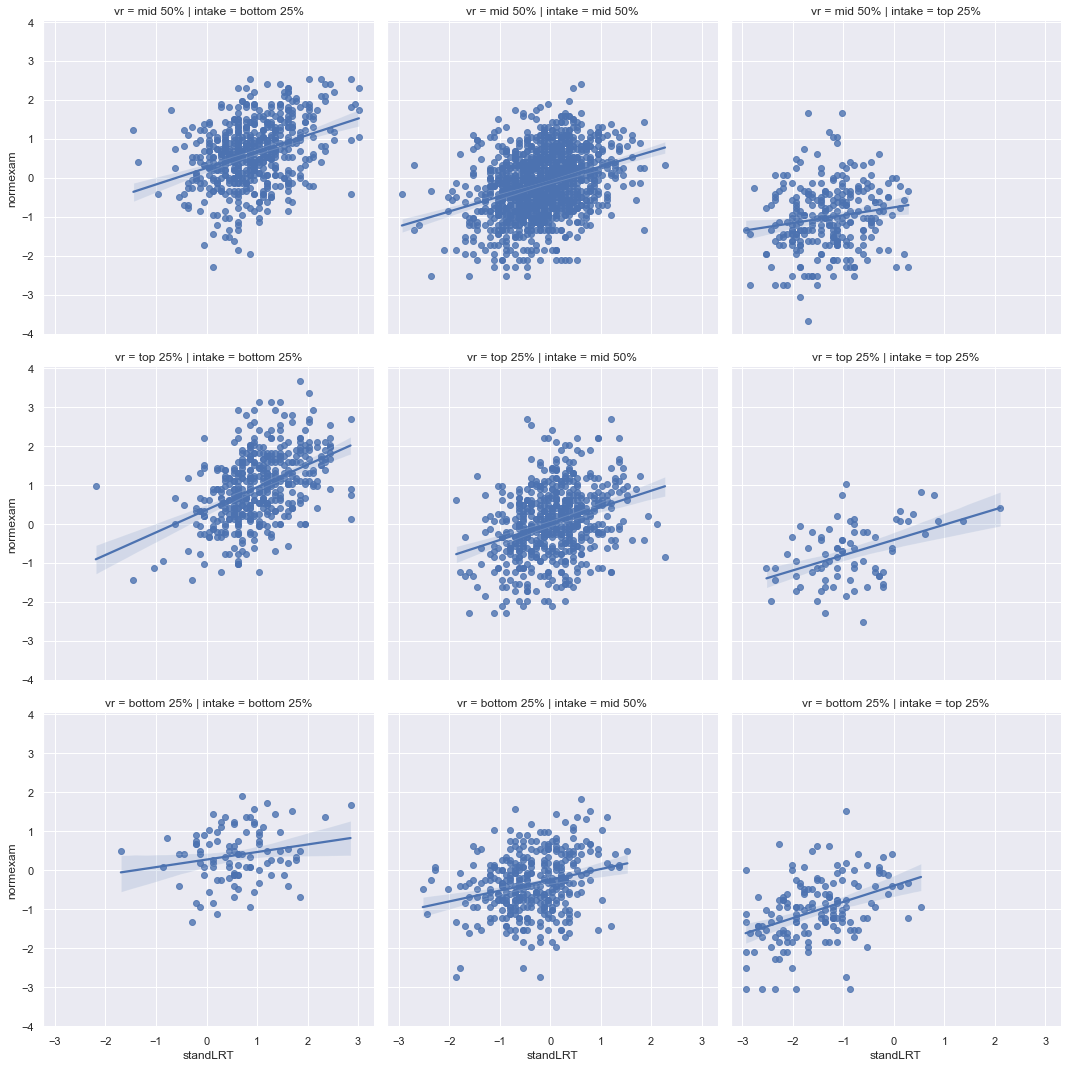

In [61]:
sns.lmplot(x="standLRT", y="normexam", data=df4, col='intake', row='vr');
# COMENTÀRIO: Há uma grande dispersão para cada uma das faixas, mesmo dividindo os dados pelas categóricas intake e vr.
# Vale ressaltar que todas as relações são positivas

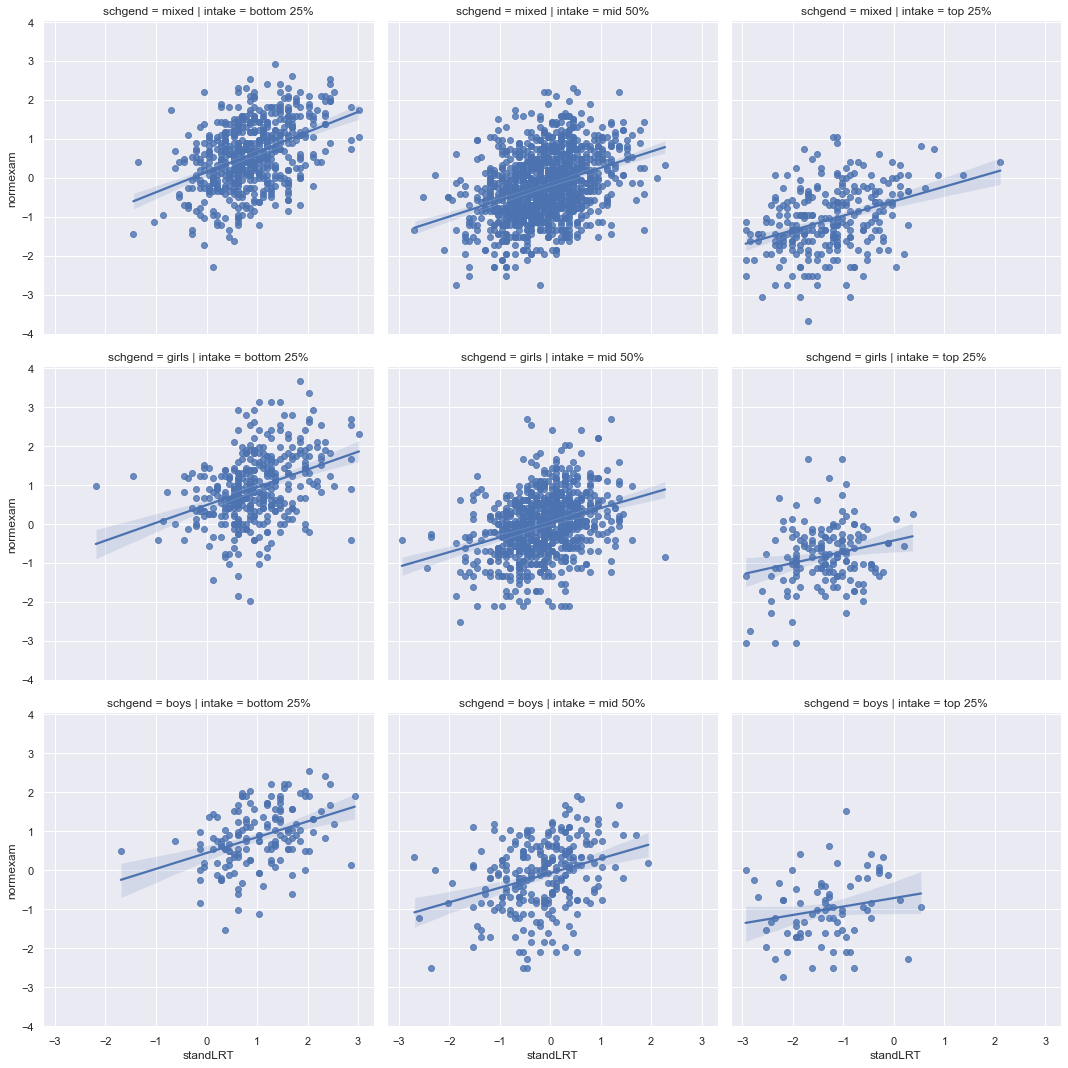

In [62]:
sns.lmplot(x="standLRT", y="normexam", data=df4, col='intake', row='schgend');
# COMENTARIO: incluindo a variável schgend junto com a intake não há uma mudança significativa na tendência do gráfico.

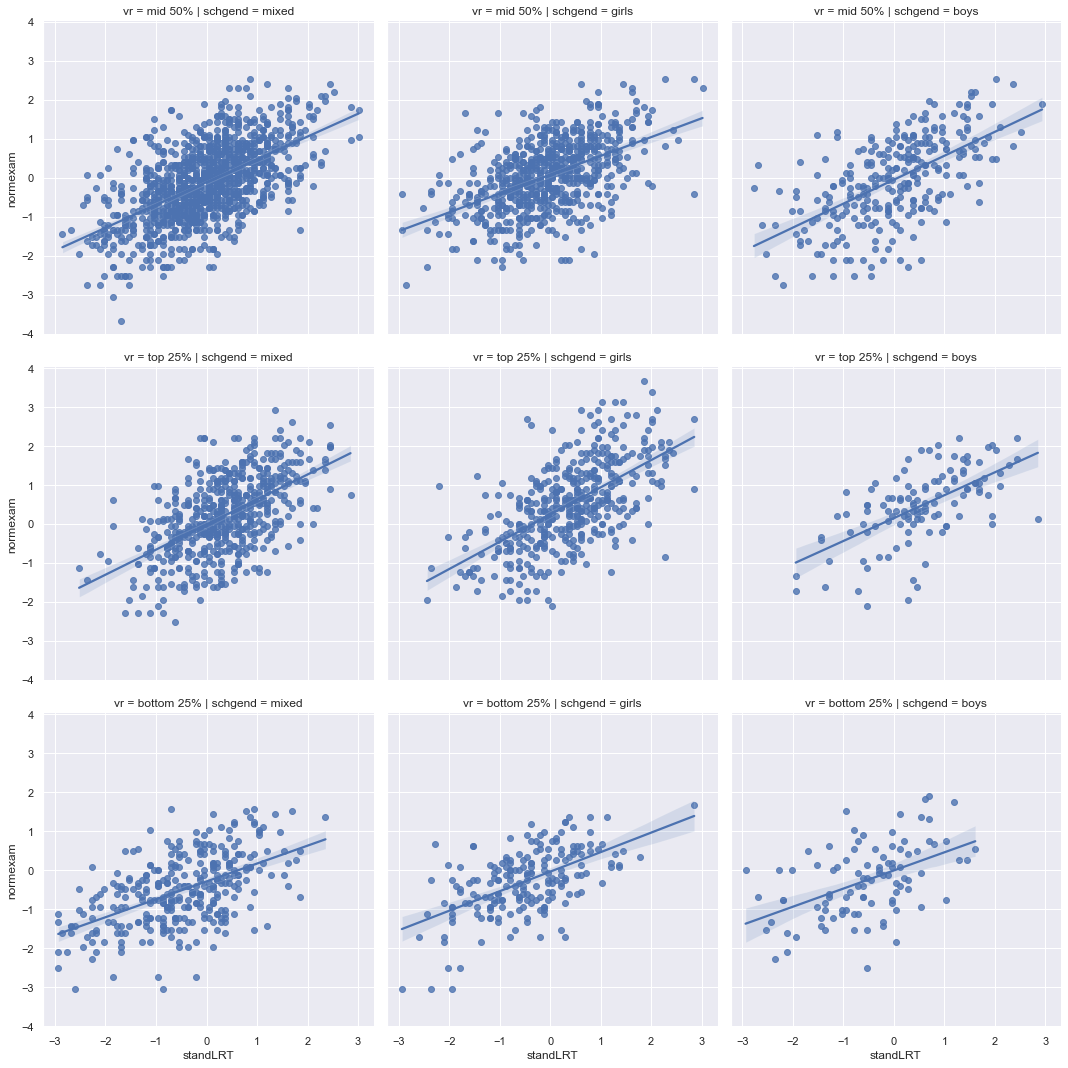

In [63]:
sns.lmplot(x="standLRT", y="normexam", data=df4, col='schgend', row='vr');

### normexam vs schavg

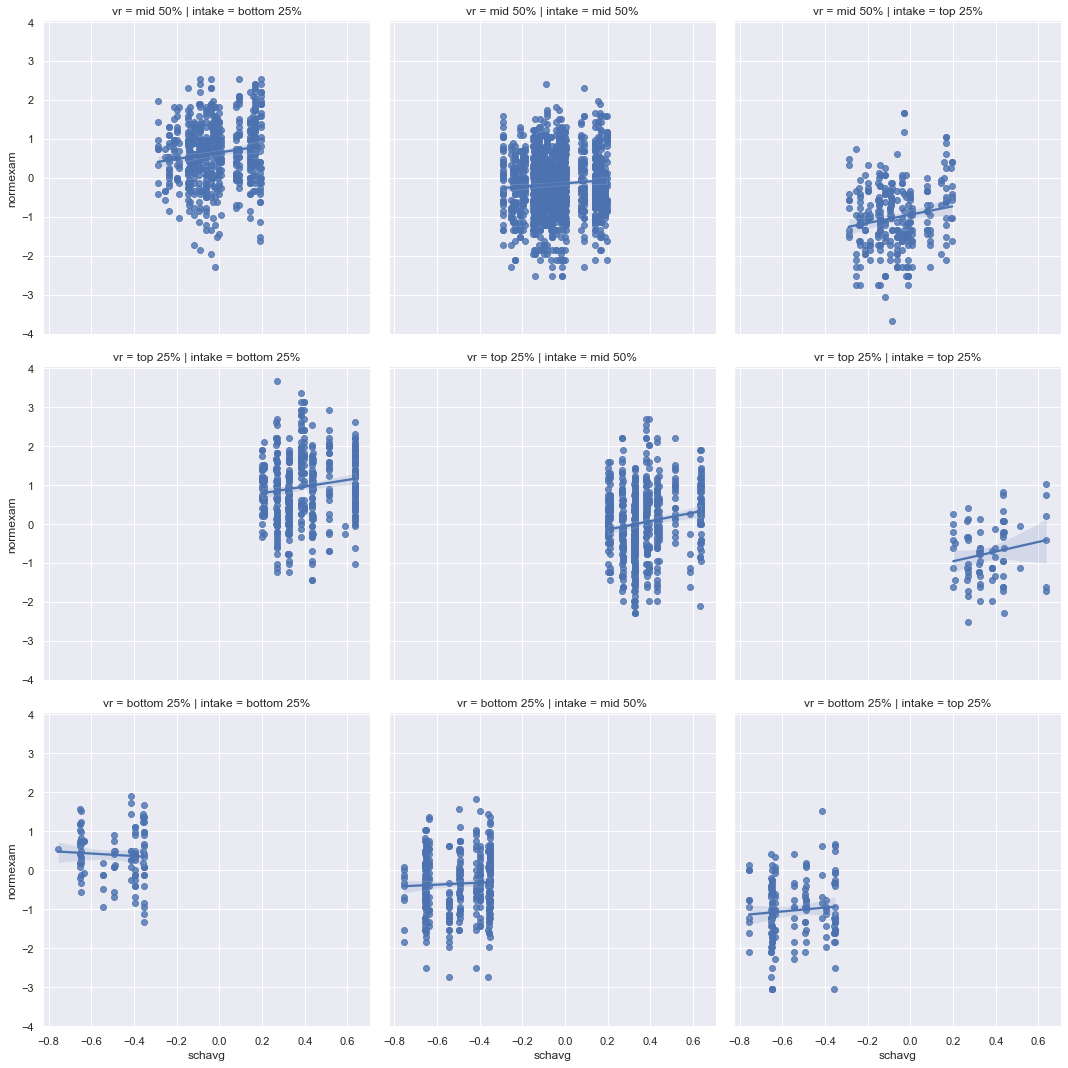

In [64]:
# normexam vs schavg
sns.lmplot(x="schavg", y="normexam", data=df4, col='intake', row='vr');
# COMENTÀRIO: Há uma grande dispersão para cada uma das faixas, mesmo dividindo os dados pelas categóricas intake e vr.
# Importante mencionar que a unica relação negativa occore no vr e intake com bottom25% indicando uma tendência de queda das notas.

## 4.3. MULTIVARIABLE ANALYSIS

### 4.3.1. NUMERICAL ATTIBUTES

<AxesSubplot:>

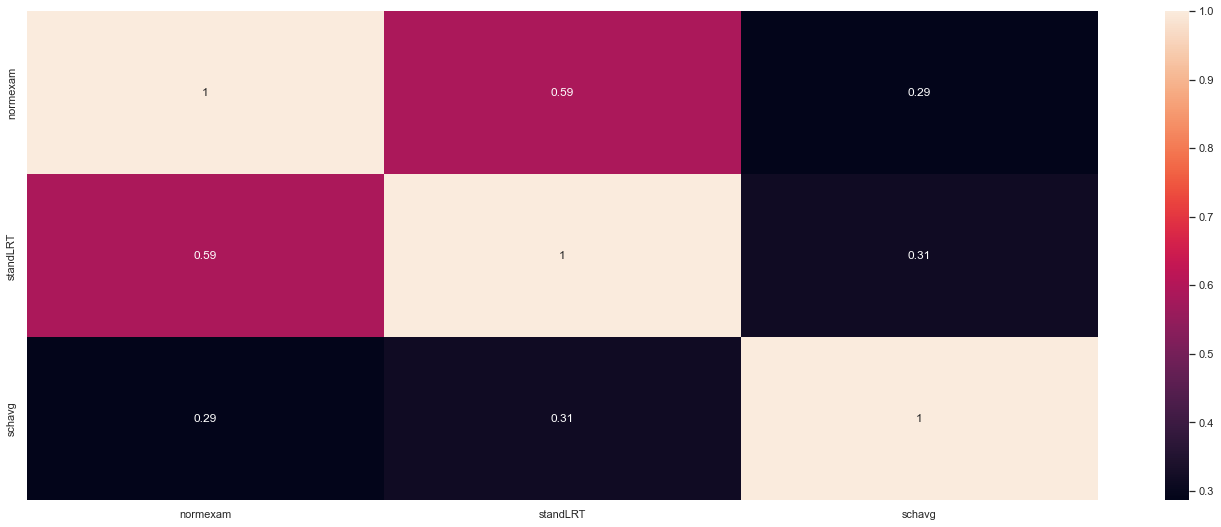

In [65]:
correlation = num_attributes.corr(method ='pearson')
sns.heatmap(correlation, annot=True)

### 4.3.2. CATEGORICAL ATTRIBUTES

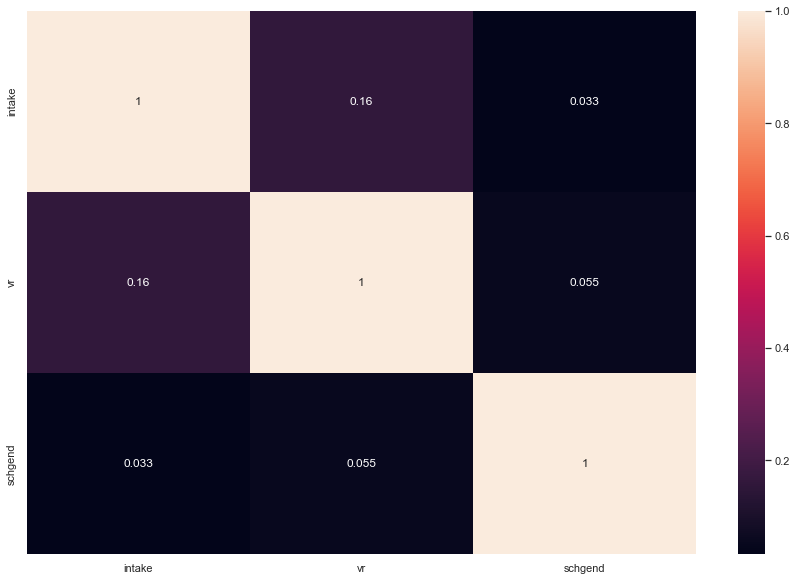

In [66]:
a = df4[['intake', 'vr', 'schgend']].copy()#.select_dtypes(include='object')
nivel = a.shape[1]
a_d = a.columns.tolist()
a_e = a.columns.tolist()

crm_l = []
for i in range(nivel):
    crm = []
    for j in range(nivel):
        crm.append(cramer_v(a[a_d[i]], a[a_e[j]]))
    crm_l.append(crm)
    
d = pd.DataFrame(crm_l)
d.columns = a_d

d = d.set_index(d.columns)
plt.figure(figsize=(15, 10))
sns.heatmap(d, annot=True)
plt.show()

# 5.0 DATA PREPARATION

In [135]:
df5 = df4.copy()
df5.head()

,school,student,normexam,standLRT,intake,schgend,schavg,vr
0,1,1,1.5062,0.7844,bottom 25%,mixed,0.1662,mid 50%
1,1,4,-0.5551,-1.0340,mid 50%,mixed,0.1662,mid 50%
2,1,6,-1.3353,-0.9513,mid 50%,mixed,0.1662,mid 50%
3,1,7,-0.5551,-2.3564,top 25%,mixed,0.1662,mid 50%
4,1,13,-0.1976,-0.2901,mid 50%,mixed,0.1662,mid 50%


In [136]:
df5_ = df5.copy()
num_attributes = df5_.select_dtypes(include=('int64', 'float64'))
cat_attributes = df5_.select_dtypes(exclude=('int64', 'float64', 'datetime64[ns]'))

In [137]:
# Verificando normalidade dos dados (numéricos)
normal_test(num_attributes)

,Shapiro-Wilk Test,D’Agostino’s K-squared,Anderson-Darling,Chi-Square,Lilliefors,Jarque–Bera,Kolmogorov-Smirnov
normexam,Test not possible,H0 can be rejected - Prob. Gaussian,H0 cannot be rejected - Prob. not Gaussian,H0 cannot be rejected - Prob. not Gaussian,H0 cannot be rejected - Prob. not Gaussian,H0 can be rejected - Prob. Gaussian,H0 can be rejected - Prob. Gaussian
standLRT,Test not possible,H0 cannot be rejected - Prob. not Gaussian,H0 cannot be rejected - Prob. not Gaussian,H0 cannot be rejected - Prob. not Gaussian,H0 cannot be rejected - Prob. not Gaussian,H0 cannot be rejected - Prob. not Gaussian,H0 cannot be rejected - Prob. not Gaussian
schavg,Test not possible,H0 cannot be rejected - Prob. not Gaussian,H0 cannot be rejected - Prob. not Gaussian,H0 cannot be rejected - Prob. not Gaussian,H0 cannot be rejected - Prob. not Gaussian,H0 cannot be rejected - Prob. not Gaussian,H0 cannot be rejected - Prob. not Gaussian


In [138]:
num_attributes.describe().T

,count,mean,std,min,25%,50%,75%,max
normexam,3842.0000,0.0052,0.9981,-3.6661,-0.6995,0.0043,0.6788,3.6661
standLRT,3842.0000,0.0115,0.9883,-2.9350,-0.6207,0.0405,0.6191,3.0160
schavg,3842.0000,0.0032,0.3167,-0.7560,-0.1493,-0.0131,0.2674,0.6377


In [139]:
# NUMERICAL VALUES
mms = MinMaxScaler()
mms_columns = ['standLRT', 'schavg']             

#Min-Max Scaler
df5_[mms_columns] = mms.fit_transform(df5_[mms_columns])

In [140]:
cat_attributes.head()

,school,student,intake,schgend,vr
0,1,1,bottom 25%,mixed,mid 50%
1,1,4,mid 50%,mixed,mid 50%
2,1,6,mid 50%,mixed,mid 50%
3,1,7,top 25%,mixed,mid 50%
4,1,13,mid 50%,mixed,mid 50%


In [141]:
cat_attributes['schgend'].unique()

array(['mixed', 'girls', 'boys'], dtype=object)

In [142]:
encoder_intake_vr = {'bottom 25%': 1, 'mid 50%': 2, 'top 25%': 3}

# CATEGORICAL VALUES
#intake - Ordinal Encoding
df5_['intake'] = df5_['intake'].map(encoder_intake_vr)

#vr - Ordinal Encoding
df5_['vr'] = df5_['vr'].map(encoder_intake_vr)

#schgend - OHE
df5_ = pd.get_dummies(df5_, prefix=['schgend'], columns=['schgend'])

In [143]:
# RESPONSE VARIABLE TRANSFORMATION
mms_rp = MinMaxScaler()
df5_['normexam'] = mms_rp.fit_transform(df5_[['normexam']])

In [144]:
df5_.head()

,school,student,normexam,standLRT,intake,schavg,vr,schgend_boys,schgend_girls,schgend_mixed
0,1,1,0.7054,0.6250,1,0.6617,2,0,0,1
1,1,4,0.4243,0.3194,2,0.6617,2,0,0,1
2,1,6,0.3179,0.3333,2,0.6617,2,0,0,1
3,1,7,0.4243,0.0972,3,0.6617,2,0,0,1
4,1,13,0.4730,0.4444,2,0.6617,2,0,0,1


# 6.0 FEATURE SELECTION

In [145]:
df6 = df5_.copy()
df6.head()

,school,student,normexam,standLRT,intake,schavg,vr,schgend_boys,schgend_girls,schgend_mixed
0,1,1,0.7054,0.6250,1,0.6617,2,0,0,1
1,1,4,0.4243,0.3194,2,0.6617,2,0,0,1
2,1,6,0.3179,0.3333,2,0.6617,2,0,0,1
3,1,7,0.4243,0.0972,3,0.6617,2,0,0,1
4,1,13,0.4730,0.4444,2,0.6617,2,0,0,1


In [146]:
X = df6.drop(['normexam'], axis=1 )
y = df6['normexam'].copy()

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(2881, 9) (2881,)
(961, 9) (961,)


## 6.1. BORUTA AS FEATURE SELECTOR

In [79]:
#training and test dataset for Boruta
X_train_n = X_train.drop(columns=['school', 'student']).values
y_train_n = y_train.values #ravel coverter em vetor

#define RandomForestRegressor
rf = RandomForestRegressor(n_jobs=-1)

#define Boruta
boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, y_train_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	7
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	7
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	7
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	7
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	7
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	7
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	7
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	3
Tentative: 	0
Rejected: 	4


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	3
Tentative: 	0
Rejected: 	4


#### 6.2.1.1 BEST FEATURES FROM BORUTA

In [80]:
cols_selected = boruta.support_.tolist()

# best features
X_train_fs = X_train.drop(columns=['school', 'student'])
sf_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

sf_boruta

['standLRT', 'intake', 'schavg']

## 6.2 EXTRA TREE - Regressor

In [81]:
#model definition
forest = ExtraTreesRegressor(n_estimators=250, random_state=0, n_jobs=-1)

x_train_n = X_train.drop(columns=['school', 'student'])
y_train_n = y_train.values

forest.fit(x_train_n, y_train_n)

ExtraTreesRegressor(n_estimators=250, n_jobs=-1, random_state=0)

Feature ranking: 
         feature  importance  acumulative
0       standLRT      0.3553       0.3553
0         intake      0.3104       0.6657
0         schavg      0.2668       0.9325
0             vr      0.0279       0.9604
0  schgend_girls      0.0163       0.9767
0  schgend_mixed      0.0149       0.9916
0   schgend_boys      0.0084       1.0000


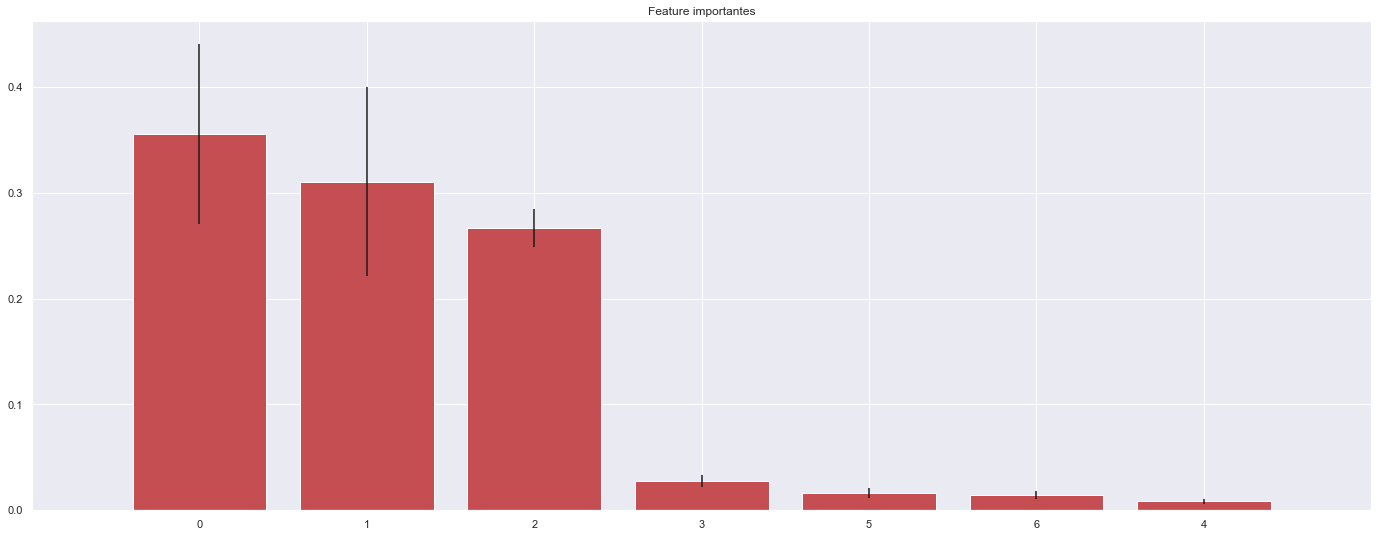

In [82]:
importances = forest.feature_importances_ #get the values of features
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0) #take the std from the feature selector
indices = np.argsort(importances)[::-1] #organize the indice by descendent

# Print the feature ranking
print("Feature ranking: ")
df = pd.DataFrame()
for i, j in zip(x_train_n.columns.values, forest.feature_importances_):
    aux = pd.DataFrame({'feature': i, 'importance': j}, index=[0])
    df = pd.concat([df, aux], axis=0)
    df = df.sort_values('importance', ascending=False)
    df['acumulative'] = df['importance'].cumsum()
    
print (df)

# Plot the impurity-bases feature importances of the forest
plt.figure()
plt.title('Feature importantes')
plt.bar(range(x_train_n.shape[1]), importances[indices], color='r',
        yerr=std[indices], align='center')
plt.xticks(range(x_train_n.shape[1]), indices)
plt.xlim([-1, x_train_n.shape[1]])
plt.show()

In [83]:
sf_et = ['standLRT', 'intake', 'schavg']

## 6.3 XGBoost - Regressor

In [84]:
#model definition
xgb_model = xgb.XGBRegressor()

x_train_n = X_train.drop(columns=['school', 'student'])
y_train_n = y_train.values

xgb_model.fit(x_train_n, y_train_n)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

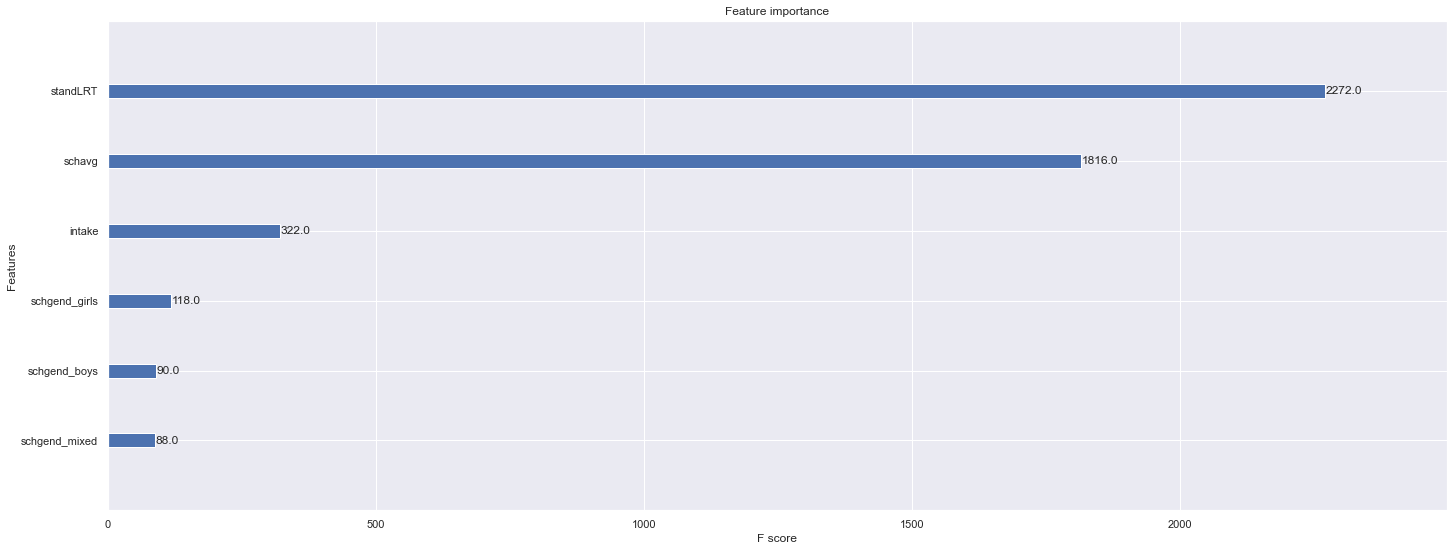

In [85]:
xgb.plot_importance(xgb_model)

In [86]:
sf_xgb = ['standLRT', 'schavg', 'intake']

## 6.4 mRMR - Regressor

In [87]:
sf_mRMR = mrmr_regression(X=X_train.drop(columns=['school', 'student']), y=y_train, K=5)
sf_mRMR

100%|██████████| 5/5 [00:03<00:00,  1.37it/s]


['standLRT', 'schgend_girls', 'intake', 'schavg', 'vr']

# 7.0 MACHINE LEARNING MODELLING

In [197]:
sf_boruta = ['standLRT', 'intake', 'schavg']
sf_et = ['standLRT', 'schavg', 'intake']
sf_xgb = ['standLRT', 'schavg', 'intake']
sf_mRMR = ['standLRT', 'schgend_girls', 'intake', 'schavg', 'vr']

final_features = sf_xgb.copy()

In [198]:
x_train = X_train[final_features]
x_test = X_val[final_features]

feat_to_add = ['normexam']
final_features_full = final_features.copy()
final_features_full.extend(feat_to_add)
x_training = df6[final_features_full]

In [199]:
def mean_percentage_error(y, yhat):
    return np.mean((y - yhat)/y)

def ml_error(model_name, y, yhat):
    Y = pd.DataFrame([y]).T.copy()
    Y.columns = ['normexam']
    P = pd.DataFrame([yhat]).T.copy().rename(columns={0:'prediction'})
    T = pd.concat([Y, P], axis=1)
    T['diff'] = abs(T['normexam'] - T['prediction'])
    T['div'] = T['normexam'].apply(lambda x: 1 if x == 0 else x)
    T['mape_p'] = T['diff']/T['div']
    mape = T['mape_p'].sum()/T.shape[0]
    
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({'Model Name': model_name,
                        'MAE': round(mae,2),
                        'MAPE': round(mape,2),
                        'RMSE': round(rmse,2)
                        }, index=[0])

def cross_validation(k, data, model, escaler, Verbose = True):
    kfold = KFold(n_splits=k, shuffle=True, random_state=28)
    mae_list = []
    mape_list = []    
    rmse_list = []

    i=1
    x_ = data.drop(['normexam'], axis=1 )
    y_ = data[['normexam']].copy()
    for train_cv, val_cv in kfold.split(x_, y_):        
        if Verbose == True:      
            print(f'Fold Number {i}/{k}')            
        else:
            pass      
        x_train_fold_k = x_.iloc[train_cv].copy()
        y_train_fold_k = y_.iloc[train_cv].copy()
        x_val_fold_k = x_.iloc[val_cv].copy()
        y_val_fold_k = y_.iloc[val_cv].copy()
            
        model_fit = model.fit(x_train_fold_k, y_train_fold_k)
        yhat_ = model_fit.predict(x_val_fold_k)
        
        y_val_mms_ = pd.DataFrame(mms_rp.inverse_transform(y_val_fold_k))
        yhat_mms_ = pd.DataFrame(mms_rp.inverse_transform(pd.DataFrame(yhat_)))
        
        # MAE
        mae = mean_absolute_error(y_val_mms_[0].values, yhat_mms_[0].values)
        mae_list.append(mae)
        
        # MAPE
        mape = mean_absolute_percentage_error(y_val_mms_[0].values, yhat_mms_[0].values)
        mape_list.append(mape)
        
        # RMSE
        rmse = np.sqrt(mean_squared_error(y_val_mms_[0].values, yhat_mms_[0].values))
        rmse_list.append(rmse)

        i+=1
        
    return pd.DataFrame({'Model Name': type(model).__name__, 
                         'MAE CV': np.round(np.mean(mae_list), 2).astype('str') + '+/-' + np.round(np.std(mae_list), 2).astype('str'),
                         'MAPE CV': np.round(np.mean(mape_list), 2).astype('str') + '+/-' + np.round(np.std(mape_list), 2).astype('str'),
                         'RMSE CV': np.round(np.mean(rmse_list), 2).astype('str') + '+/-' + np.round(np.std(rmse_list), 2).astype('str')
                         },
                      index=[0])

## 7.1 AVERAGE MODEL

In [200]:
#prediction
yhat_baseline = X_val[['school']].copy()
yhat_baseline['normexam'] = y_train.mean()

y_val_ = pd.DataFrame(mms_rp.inverse_transform(y_val.to_frame()))
yhat_baseline_ = pd.DataFrame(mms_rp.inverse_transform(yhat_baseline[['normexam']]))

#performance
baseline_result = ml_error('Average Model', y_val_[0].values, yhat_baseline_[0].values)
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,0.7900,0.9900,0.9900


## 7.2 LINEAR REGRESSION MODEL

In [201]:
#model
lr = LinearRegression().fit(x_train, y_train)

#prediction
yhat_lr = lr.predict(x_test)

y_val_ = pd.DataFrame(mms_rp.inverse_transform(y_val.to_frame()))
yhat_lr_ = pd.DataFrame(mms_rp.inverse_transform(pd.DataFrame(yhat_lr)))

#performance
lr_result = ml_error('Linear Regression', y_val_[0].values, yhat_lr_[0].values)
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,0.6000,3.7600,0.7600


### 7.2.1. LINEAR REGRESSION MODEL - CROSS VALIDATION

In [202]:
lr_result_cv = cross_validation(5, x_training, lr, mms_rp)
lr_result_cv

Fold Number 1/5
Fold Number 2/5
Fold Number 3/5
Fold Number 4/5
Fold Number 5/5


,Model Name,MAE CV,MAPE CV,RMSE CV
0,LinearRegression,0.62+/-0.01,4.06+/-0.62,0.78+/-0.01


## 7.3 LINEAR REGRESSION REGULARIZED MODEL - LASSO

In [203]:
#model
lrr = Lasso(alpha=0.01).fit(x_train, y_train)

#prediction
yhat_lrr = lrr.predict(x_test)

y_val_ = pd.DataFrame(mms_rp.inverse_transform(y_val.to_frame()))
yhat_lrr_ = pd.DataFrame(mms_rp.inverse_transform(pd.DataFrame(yhat_lrr)))

#performance
lrr_result = ml_error('Linear Regression - Lasso', y_val_[0].values, yhat_lrr_[0].values)
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,0.6700,3.0600,0.8400


### 7.3.1. LINEAR REGRESSION REGULARIZED MODEL - LASSO - CROSS VALIDATION

In [204]:
lrr_result_cv = cross_validation(5, x_training, lrr, mms_rp)
lrr_result_cv

Fold Number 1/5
Fold Number 2/5
Fold Number 3/5
Fold Number 4/5
Fold Number 5/5


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,0.67+/-0.01,3.06+/-0.63,0.85+/-0.01


## 7.4. RANDOM FOREST REGRESSOR

In [205]:
#model
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(x_train, y_train)

#prediction
yhat_rf = rf.predict(x_test)

y_val_ = pd.DataFrame(mms_rp.inverse_transform(y_val.to_frame()))
yhat_rf_ = pd.DataFrame(mms_rp.inverse_transform(pd.DataFrame(yhat_rf)))

#performance
rf_result = ml_error('Random Forest Regressor', y_val_[0].values, yhat_rf_[0].values)
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,0.6500,4.4300,0.8200


### 7.4.1. RANDOM FOREST REGRESSOR - CROSS VALIDATION

In [206]:
rf_result_cv = cross_validation(5, x_training, rf, mms_rp)
rf_result_cv

Fold Number 1/5
Fold Number 2/5
Fold Number 3/5
Fold Number 4/5
Fold Number 5/5


,Model Name,MAE CV,MAPE CV,RMSE CV
0,RandomForestRegressor,0.67+/-0.01,4.93+/-1.04,0.84+/-0.02


## 7.5. XGBOOST REGRESSOR

In [207]:
#model
model_xgb = xgb.XGBRegressor().fit(x_train, y_train, verbose=True)

#prediction
yhat_xgb = model_xgb.predict(x_test)

y_val_ = pd.DataFrame(mms_rp.inverse_transform(y_val.to_frame()))
yhat_xgb_ = pd.DataFrame(mms_rp.inverse_transform(pd.DataFrame(yhat_xgb)))

#performance
xgb_result = ml_error('XGBoost Regressor', y_val_[0].values, yhat_xgb_[0].values)
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,0.6100,3.7000,0.7900


### 7.5.1. XGBOOST REGRESSOR - CROSS VALIDATION

In [208]:
xgb_result_cv = cross_validation(5, x_training, model_xgb, mms_rp)
xgb_result_cv

Fold Number 1/5
Fold Number 2/5
Fold Number 3/5
Fold Number 4/5
Fold Number 5/5


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBRegressor,0.64+/-0.01,4.4+/-0.84,0.81+/-0.01


## 7.6. Light GBM REGRESSOR

In [209]:
#model
model_lgbm = lgbm.LGBMRegressor().fit(x_train, y_train, verbose=True)

#prediction
yhat_lgbm = model_lgbm.predict(x_test)

y_val_ = pd.DataFrame(mms_rp.inverse_transform(y_val.to_frame()))
yhat_lgbm_ = pd.DataFrame(mms_rp.inverse_transform(pd.DataFrame(yhat_lgbm)))

#performance
lgbm_result = ml_error('Light GBM Regressor', y_val_[0].values, yhat_lgbm_[0].values)
lgbm_result

,Model Name,MAE,MAPE,RMSE
0,Light GBM Regressor,0.5900,3.7000,0.7500


### 7.6.1. XGBOOST REGRESSOR - CROSS VALIDATION

In [210]:
lgbm_result_cv = cross_validation(5, x_training, model_xgb, mms_rp)
lgbm_result_cv

Fold Number 1/5
Fold Number 2/5
Fold Number 3/5
Fold Number 4/5
Fold Number 5/5


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBRegressor,0.64+/-0.01,4.4+/-0.84,0.81+/-0.01


## 7.7 COMPARE MODELS PERFORMANCE

### 7.7.1. SINGLE PERFORMANCE

In [195]:
# Maximum Relevance — Minimum Redundancy - Features
modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result, lgbm_result])
modelling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Light GBM Regressor,0.5800,3.6700,0.7400
0,Linear Regression,0.6000,3.8100,0.7600
0,XGBoost Regressor,0.6200,4.1600,0.8000
0,Random Forest Regressor,0.6400,4.4500,0.8200
0,Linear Regression - Lasso,0.6600,3.0100,0.8300
0,Average Model,0.7900,0.9900,0.9900


In [211]:
# XGBoost / Extra Trees / Boruta - Features
modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result, lgbm_result])
modelling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Light GBM Regressor,0.5900,3.7000,0.7500
0,Linear Regression,0.6000,3.7600,0.7600
0,XGBoost Regressor,0.6100,3.7000,0.7900
0,Random Forest Regressor,0.6500,4.4300,0.8200
0,Linear Regression - Lasso,0.6700,3.0600,0.8400
0,Average Model,0.7900,0.9900,0.9900


### 7.72. REAL PERFORMANCE - CROSS VALIDATION

In [196]:
# Maximum Relevance — Minimum Redundancy - Features
modelling_result_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv, lgbm_result_cv])
modelling_result_cv.sort_values('RMSE CV')

,Model Name,MAE CV,MAPE CV,RMSE CV
0,LinearRegression,0.61+/-0.01,4.15+/-0.63,0.77+/-0.01
0,XGBRegressor,0.64+/-0.01,4.45+/-0.73,0.81+/-0.01
0,XGBRegressor,0.64+/-0.01,4.45+/-0.73,0.81+/-0.01
0,Lasso,0.67+/-0.0,3.09+/-0.66,0.84+/-0.01
0,RandomForestRegressor,0.66+/-0.01,4.83+/-0.91,0.84+/-0.02


In [212]:
# XGBoost / Extra Trees / Boruta - Features
modelling_result_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv, lgbm_result_cv])
modelling_result_cv.sort_values('RMSE CV')

,Model Name,MAE CV,MAPE CV,RMSE CV
0,LinearRegression,0.62+/-0.01,4.06+/-0.62,0.78+/-0.01
0,XGBRegressor,0.64+/-0.01,4.4+/-0.84,0.81+/-0.01
0,XGBRegressor,0.64+/-0.01,4.4+/-0.84,0.81+/-0.01
0,RandomForestRegressor,0.67+/-0.01,4.93+/-1.04,0.84+/-0.02
0,Lasso,0.67+/-0.01,3.06+/-0.63,0.85+/-0.01
